In [1]:
import torch
from matplotlib import pyplot as plt
from the_well.data import WellDataset
from torch.utils.data import DataLoader
import numpy as np

from dataclasses import dataclass
from datasets import load_dataset

from torchvision import transforms
import torch

from accelerate import Accelerator
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
import os
import torch.nn.functional as F
from matplotlib import pyplot as plt
from accelerate import notebook_launcher
from diffusers.optimization import get_cosine_schedule_with_warmup
from diffusers import UNet2DModel
from diffusers import DDPMScheduler
from diffusers import DDPMPipeline
from diffusers.utils import make_image_grid
import os
from PIL import Image
import glob
import numpy as np
from torchvision.transforms import InterpolationMode

In [2]:
@dataclass
class TrainingConfig:
    image_size = 128  
    train_batch_size = 16
    eval_batch_size = 16  
    num_epochs = 100
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 10
    mixed_precision = "fp16" 
    output_dir = "ddpm-butterflies-upscaling-128" 

    push_to_hub = False  
    overwrite_output_dir = True 
    seed = 42
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



config = TrainingConfig()

In [3]:

dataset_name = "huggan/smithsonian_butterflies_subset"
dataset = load_dataset(dataset_name, split="train")

Repo card metadata block was not found. Setting CardData to empty.


In [4]:
def pad_to_square(image):
    width, height = image.size
    
    max_dim = max(width, height)
    
    pad_left = (max_dim - width) // 2
    pad_right = max_dim - width - pad_left
    pad_top = (max_dim - height) // 2
    pad_bottom = max_dim - height - pad_top
    
    padding = (pad_left, pad_top, pad_right, pad_bottom)
    return transforms.Pad(padding, fill = 255, padding_mode = 'constant')(image)

preprocess = transforms.Compose([
    transforms.Lambda(pad_to_square),  
    transforms.Resize((config.image_size, config.image_size)),
])

high_res_preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

low_res_preprocess_new_dim = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: F.avg_pool2d(x, kernel_size=2)),
    transforms.Normalize([0.5], [0.5]),
])

low_res_preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: F.avg_pool2d(x, kernel_size=2)),
    transforms.Resize(
        (config.image_size, config.image_size),  
        interpolation=InterpolationMode.NEAREST_EXACT 
    ),
    transforms.Normalize([0.5], [0.5]),
])

def transform(examples):
    high_res_images = []
    low_res_images = []
    low_res_images_new_dim = []
    for image in examples['image']:
        pre_img = preprocess(image.convert("RGB"))
        high_res_images.append(high_res_preprocess(pre_img))
        low_res_images.append(low_res_preprocess(pre_img))
        low_res_images_new_dim.append(low_res_preprocess_new_dim(pre_img))
    
    return {
        "high_res_images": high_res_images,
        "low_res_images": low_res_images,
        'low_res_images_new_dim': low_res_images_new_dim
    }

dataset.set_transform(transform)

In [5]:
dataset2= WellDataset(
    well_base_path="./the_well/datasets/",
    well_dataset_name="active_matter",
    well_split_name="train"
)

avg_pool = torch.nn.AvgPool2d(kernel_size=2, stride=2)

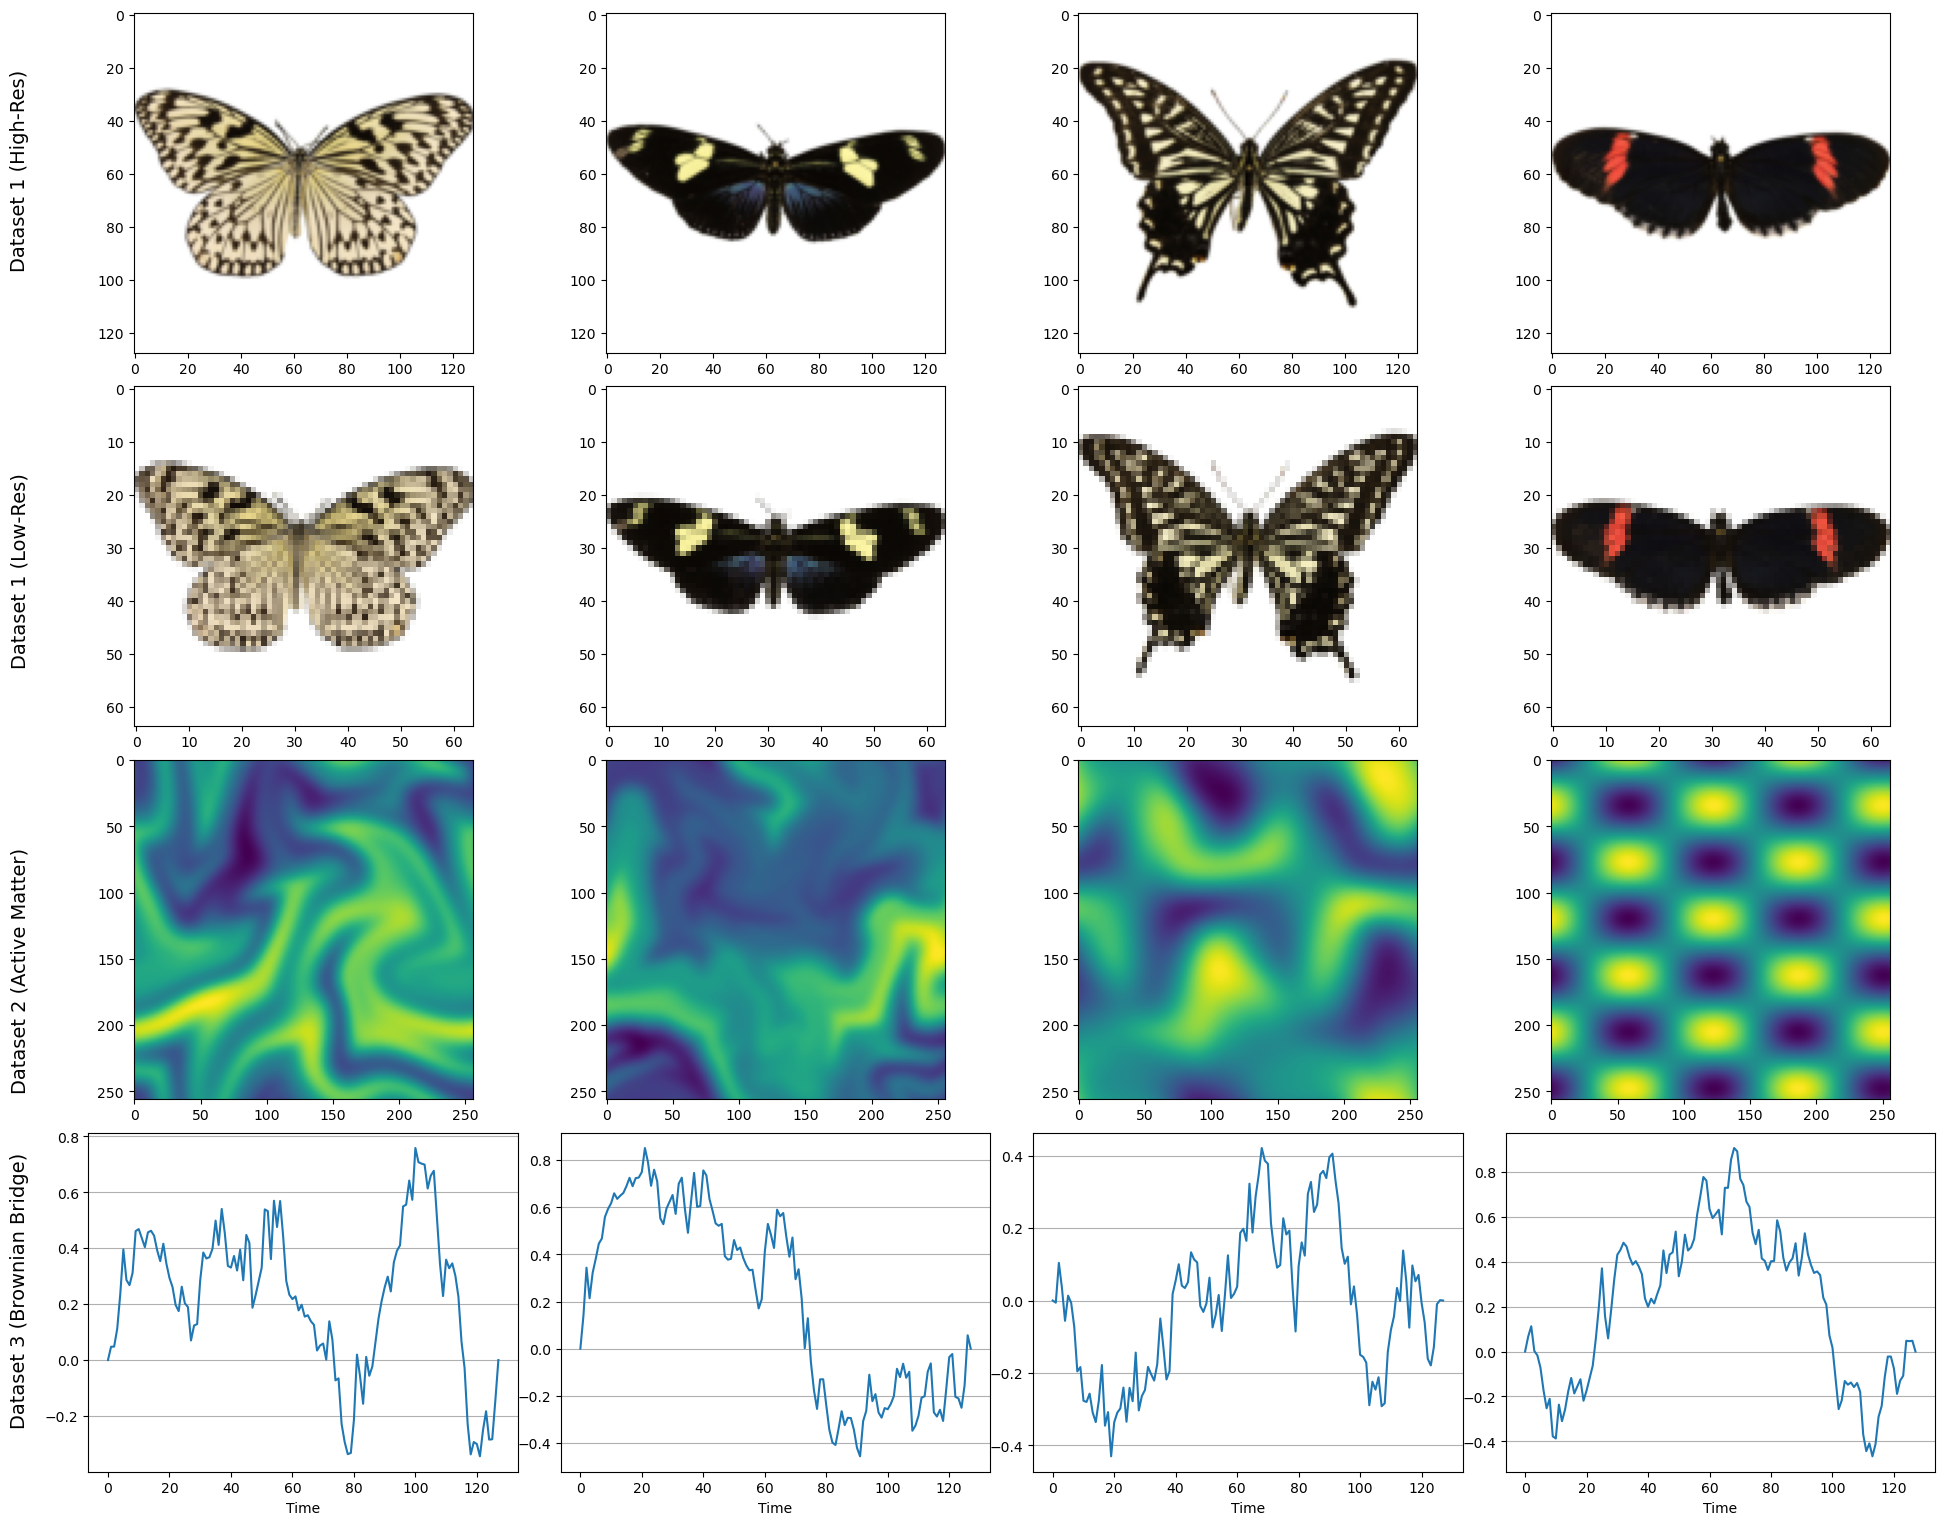

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib

plt.style.use('default')
matplotlib.rcParams['figure.figsize'] = (20, 16)

def undo_normalize(tensor):
    return (tensor + 1) / 2


class BrownianBridgeDataset(Dataset):
    def __init__(self, num_samples=1000, seq_len=64, end_point=0.0):
        self.num_samples = num_samples
        self.seq_len = seq_len
        self.end_point = end_point
        self.data = self.sample_path_batch(self.num_samples, self.seq_len)
    
    def sample_path_batch(self, M, N):
        dt = 1.0 / (N - 1)
        dt_sqrt = np.sqrt(dt)
        B = np.empty((M, N), dtype=np.float32)
        B[:, 0] = 0
        for n in range(N - 2):
            t = n * dt
            xi = np.random.randn(M) * dt_sqrt
            B[:, n + 1] = B[:, n] * (1 - dt / (1 - t)) + xi
        B[:, -1] = self.end_point
        
        # Calculate X as the jumps that sum to bridge B
        X = np.empty((M, N), dtype=np.float32)
        X[:, 0] = B[:, 0]  # First point
        X[:, 1:] = B[:, 1:] - B[:, :-1]  # Differences
        
        return torch.from_numpy(X), torch.from_numpy(B)
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        return {"X": self.data[0][idx], "BB": self.data[1][idx]}


def create_dataset_visualization_grid(dataset):
    # Create the main figure with 4x4 grid
    fig, axs = plt.subplots(4, 4, figsize=(20, 16))
    
    # Dataset 1 - High Res and Low Res Images (Rows 1 and 2)
    high_res_images = dataset[:4]["high_res_images"]
    low_res_images = dataset[:4]["low_res_images_new_dim"]
    
    # Dataset 1 - High Resolution Images (Row 1)
    for i in range(4):
        axs[0, i].imshow(undo_normalize(high_res_images[i].permute(1, 2, 0)))
        #axs[0, i].set_axis_off()
    
    # Dataset 1 - Low Resolution Images (Row 2)
    for i in range(4):
        axs[1, i].imshow(undo_normalize(low_res_images[i].permute(1, 2, 0)))
        #axs[1, i].set_axis_off()
    
    # Dataset 2 - Well Dataset Images (Row 3)
    well_images = [dataset2[i] for i in torch.randint(len(dataset2), (4,))]

    for i in range(4):
        img = well_images[i]['input_fields'].squeeze(0).permute(2, 0, 1)[0, :, :]
        axs[2, i].imshow(img, cmap='viridis')
        #axs[2, i].set_axis_off()
    
    # Dataset 3 - Brownian Bridge (Row 4)
    bridge_dataset = BrownianBridgeDataset(num_samples=10, seq_len=128)
    
    for i in range(4):
        sample = bridge_dataset[i]["BB"]
        axs[3, i].plot(sample)
        axs[3, i].set_xlabel("Time")
        axs[3, i].grid(True)
        axs[3, i].grid(True, axis='x', alpha=0)  
    
    # Add dataset labels to the left side of each row
    fig.text(0.03, 0.85, 'Dataset 1 (High-Res)', fontsize=14, rotation=90, va='center')
    fig.text(0.03, 0.60, 'Dataset 1 (Low-Res)', fontsize=14, rotation=90, va='center')
    fig.text(0.03, 0.35, 'Dataset 2 (Active Matter)', fontsize=14, rotation=90, va='center')
    fig.text(0.03, 0.15, 'Dataset 3 (Brownian Bridge)', fontsize=14, rotation=90, va='center')
    
    plt.tight_layout(rect=[0.04, 0, 1, 0.96])  
    plt.subplots_adjust(wspace=0.1, hspace=0.1)  
    plt.savefig('dataset_visualization_grid.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

visualization_grid = create_dataset_visualization_grid(dataset)